## Importing libraries

In [1]:
import os
import re
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
from keras import layers
from keras import models
from keras import utils as np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import itertools
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling1D, Dense, BatchNormalization, Flatten
from keras.models import Model
!pip install opensmile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168840 sha256=190019b1ed0a5885b7c112314b9d369a982281f587b63c015d8e04b1dae7133c
  Stored in directory: /root/.cache/pip/wheels/d8/78/cc/5478ca3b1c3f602eae6f8cdbd78f909c0a0bfa0bbcb5c7771f
Successfully built iso-639


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
#Unzip the file contents
# !unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/SAVEE.zip' -d SAVEE
# !unzip "/content/drive/MyDrive/Colab Notebooks/Dataset/Crema.zip" -d Crema
# !unzip "/content/drive/MyDrive/Colab Notebooks/Dataset/speech-emotion-recognition-ravdess-data.zip" -d RAVDESS
# !unzip "/content/drive/MyDrive/Colab Notebooks/Dataset/Tess.zip" -d Tess


Mounted at /content/drive/


In [3]:
train_extracted_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/TESS_Train.csv')
train_extracted_df.sample(frac=1)
X = train_extracted_df.drop(labels="labels", axis=1)
Y = train_extracted_df["labels"]

In [4]:
train_extracted_df['labels'].value_counts()

labels
happy      320
sad        320
neutral    320
angry      320
ps         320
fear       320
disgust    320
Name: count, dtype: int64

In [5]:
X_train=train_extracted_df.drop(labels="labels", axis=1)
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y
y_train=Y
X_train.shape, y_train.shape

['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']


((2240, 6373), (2240, 7))

In [6]:
test_extracted_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/TESS_Test.csv')
test_extracted_df.sample(frac=1)
X_test= test_extracted_df.drop(labels="labels", axis=1)
y = test_extracted_df["labels"]
y = np_utils.to_categorical(lb.fit_transform(y))
print(lb.classes_)
y_test= y
X_test.shape, y_test.shape

['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']


((560, 6373), (560, 7))

In [7]:
# Standardize data
scaler = StandardScaler()
gen = scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2240, 6373), (560, 6373), (2240, 7), (560, 7))

In [8]:
import joblib
joblib.dump(gen,'std.pkl')

['std.pkl']

In [9]:
X_train = scaler.fit_transform(X_train)
X_train

array([[-0.71982246,  0.74039195,  1.31975727, ..., -0.02788335,
        -0.12411369,  0.49154029],
       [ 1.96933584, -0.93290795, -0.56242717, ..., -1.13085853,
        -0.88248101, -0.57864694],
       [-0.22053445,  0.65669866,  0.02610441, ..., -0.71148548,
        -0.1936573 , -0.29555493],
       ...,
       [ 0.70152038,  1.02662335,  0.20867423, ..., -0.27355324,
        -0.3331543 , -0.13185836],
       [ 0.16115756,  0.56524247, -0.92083664, ...,  1.4635162 ,
         0.07060858, -0.0438359 ],
       [-0.40704435,  1.05110373, -0.14066605, ..., -0.43825245,
        -0.78537765, -0.82539316]])

In [10]:
joblib.load('std.pkl').transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[-2.73991515,  0.81260388,  3.15815838, ..., -2.58190938,
        -3.18686261, -2.05127208],
       [ 1.38908521, -5.19528839, -5.56475872, ..., -2.62536138,
        -3.20770558, -2.08277236],
       [-1.97329596,  0.51210769, -2.83722994, ..., -2.60884007,
        -3.18877395, -2.07443973],
       ...,
       [-0.55755009,  1.84030217, -1.99111658, ..., -2.59158761,
        -3.19260788, -2.06962142],
       [-1.38723656,  0.18373921, -7.2257947 , ..., -2.52315529,
        -3.18151086, -2.06703054],
       [-2.25966787,  1.92819763, -3.61012176, ..., -2.59807598,
        -3.20503679, -2.09003518]])

In [11]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(2240, 6373, 1)

### Let's define our model:

In [12]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)


In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [14]:
from tensorflow.keras.regularizers import l2

# earlystopping = EarlyStopping(monitor="val_acc",
#                               mode='auto', patience=5,
#                               restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

model =  models.Sequential()

model.add(layers.Conv1D(16, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=3, strides=2, padding="same"))
model.add(layers.Dropout(0.3))  # Added dropout layer

model.add(layers.Conv1D(32, kernel_size=3, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=3, strides=2, padding="same"))
model.add(layers.Dropout(0.3))  # Added dropout layer

model.add(layers.Conv1D(64, kernel_size=3, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=3, strides=2, padding="same"))
model.add(layers.Dropout(0.3))  # Added dropout layer


model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6373, 16)          96        
                                                                 
 batch_normalization (Batch  (None, 6373, 16)          64        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 3187, 16)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3187, 16)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3187, 32)          1568      
                                                                 
 batch_normalization_1 (Bat  (None, 3187, 32)          1

In [16]:
EPOCHS = 30
batch_size = 64

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=EPOCHS, batch_size=batch_size, callbacks=[ learning_rate_reduction])

Epoch 1/30
35/35 [==============================] - 9s 56ms/step - loss: 1.0033 - acc: 0.7415 - val_loss: 2.5035 - val_acc: 0.1839 - lr: 0.0010
Epoch 2/30
35/35 [==============================] - 1s 37ms/step - loss: 0.5001 - acc: 0.9228 - val_loss: 4.3263 - val_acc: 0.1464 - lr: 0.0010
Epoch 3/30
35/35 [==============================] - 1s 39ms/step - loss: 0.4089 - acc: 0.9643 - val_loss: 4.9448 - val_acc: 0.2054 - lr: 0.0010
Epoch 4/30
35/35 [==============================] - 1s 36ms/step - loss: 0.3659 - acc: 0.9848 - val_loss: 4.2592 - val_acc: 0.2929 - lr: 0.0010
Epoch 5/30
35/35 [==============================] - 1s 36ms/step - loss: 0.3610 - acc: 0.9830 - val_loss: 2.8066 - val_acc: 0.4054 - lr: 0.0010
Epoch 6/30
35/35 [==============================] - 1s 34ms/step - loss: 0.3470 - acc: 0.9879 - val_loss: 1.6582 - val_acc: 0.5411 - lr: 0.0010
Epoch 7/30
35/35 [==============================] - 1s 34ms/step - loss: 0.3289 - acc: 0.9920 - val_loss: 0.7735 - val_acc: 0.8161 - lr:

In [18]:
train_acc = history.history['acc']
print("Training Accuracy:", train_acc[-1] * 100, "%")


Training Accuracy: 100.0 %


18/18 [==============================] - 0s 14ms/step - loss: 0.1384 - acc: 0.9893
Accuracy of our model on test data :  98.92857074737549 %


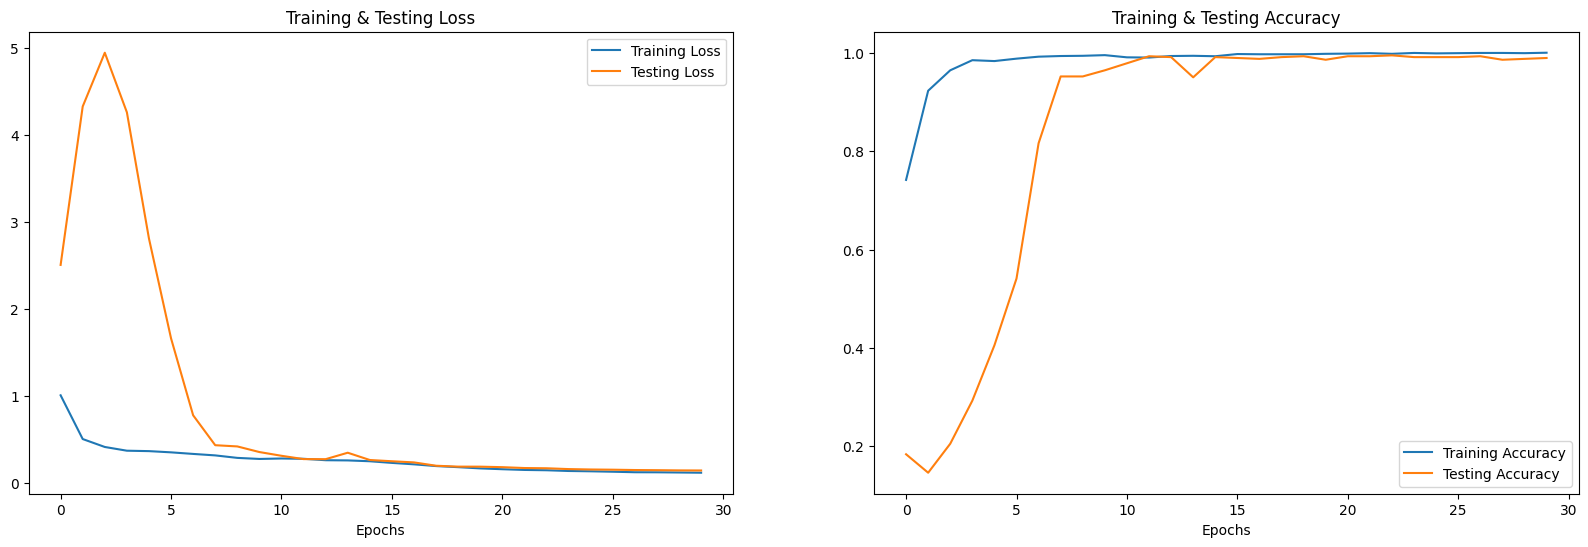

In [19]:

print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")



fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [20]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

18/18 [==============================] - 0s 5ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
y_check = np.argmax(y_test, axis=1)
y_check

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [23]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[80  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0]
 [ 0  0 80  0  0  0  0]
 [ 0  0  0 79  0  1  0]
 [ 0  0  0  0 79  0  1]
 [ 0  0  0  4  0 76  0]
 [ 0  0  0  0  0  0 80]]


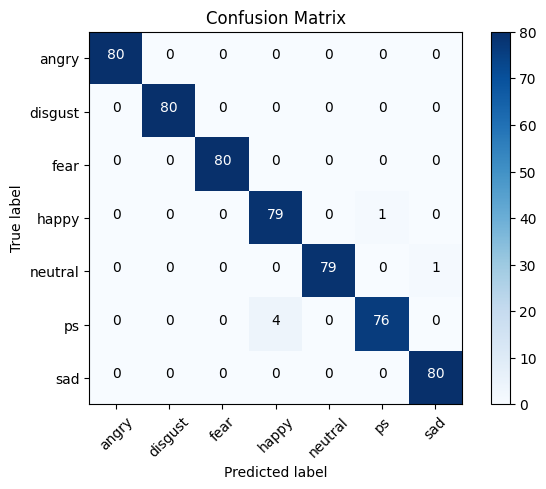

In [24]:
cm_plot_labels = lb.classes_
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
path_to_model = "./res2_model.h5"

model.save(path_to_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
path_to_model = "/content/drive/My Drive/Colab Notebooks/res2_model.h5"

model.save(path_to_model)